In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from collections import Counter

import warnings
warnings.filterwarnings('ignore')


In [2]:
!gdown 18eSRA957xCqSzIUmOQS7qKblLk7r66Ax
data = pd.read_excel('region_roles_(26.05.22).xlsx')


Downloading...
From: https://drive.google.com/uc?id=18eSRA957xCqSzIUmOQS7qKblLk7r66Ax
To: /content/region_roles_(26.05.22).xlsx
100% 84.4M/84.4M [00:00<00:00, 252MB/s]


# Подготовка данных

In [3]:
data.head(3)

,Unnamed: 0,id,premium,name,department,has_test,response_letter_required,area,salary,type,...,working_days,working_time_intervals,working_time_modes,accept_temporary,description,experience,key_skills,specializations,region,immediate_redirect_url
0,0,49059633,False,Младший специалист ручного тестирования,NaN,False,False,"{'id': '15', 'name': 'Астрахань', 'url': 'http...",NaN,"{'id': 'open', 'name': 'Открытая'}",...,[],[],[],False,<p>В некоторых проектах Яндексу помогают компа...,"{'id': 'noExperience', 'name': 'Нет опыта'}",[],"[{'id': '1.172', 'name': 'Начальный уровень, М...",Астраханская область,NaN
1,1,54653519,False,Тестировщик.Net,NaN,False,False,"{'id': '15', 'name': 'Астрахань', 'url': 'http...","{'from': 25000, 'to': 50000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",...,[],[],[],False,<p><em><strong>Мы ищем талантливого и амбициоз...,"{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Git'}, {'name': 'SQL'}, {'name': 'Т...","[{'id': '1.221', 'name': 'Программирование, Ра...",Астраханская область,NaN
2,2,55116066,False,Пентестер,NaN,False,False,"{'id': '15', 'name': 'Астрахань', 'url': 'http...",NaN,"{'id': 'open', 'name': 'Открытая'}",...,[],[],[],False,<p>Лидер на рынке систем информационной безопа...,"{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","[{'name': 'SQL'}, {'name': 'Linux'}, {'name': ...","[{'id': '1.221', 'name': 'Программирование, Ра...",Астраханская область,NaN


### Общая информация, удаление лишних колонок

In [4]:
# размер датасета

data.shape

(69656, 34)

In [5]:
# оценим, какие типы данных у колонок

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69656 entries, 0 to 69655
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                69656 non-null  int64  
 1   id                        69656 non-null  int64  
 2   premium                   69656 non-null  bool   
 3   name                      69656 non-null  object 
 4   department                5263 non-null   object 
 5   has_test                  69656 non-null  bool   
 6   response_letter_required  69656 non-null  bool   
 7   area                      69656 non-null  object 
 8   salary                    37590 non-null  object 
 9   type                      69656 non-null  object 
 10  address                   40318 non-null  object 
 11  response_url              1 non-null      object 
 12  sort_point_distance       0 non-null      float64
 13  published_at              69656 non-null  object 
 14  create

In [6]:
# в 5 колонках практически все значения отсутствуют, есть смысл их удалить. в 3 нет примерно половины значений, эти колонки пока оставим

data.isna().sum()[data.isna().sum() > 0]

department                64393
salary                    32066
address                   29338
response_url              69655
sort_point_distance       69656
insider_interview         69134
contacts                  34542
immediate_redirect_url    69655
dtype: int64

In [7]:
# колонки для удаления:
# удаляем колонки с большим количеством пропусков
# колонки ['premium', 'archived', 'relations', 'type'] имеют либо одно значение, либо во втором значении единичные элементы 
# колонка ['area', 'address'] аналогична по информативности['region']
# колонки ['url', 'alternative_url', 'contacts', 'id'] не несут смысловой нагрузки
# колонка ['snippet'] содержит обрезанное описание responsibility и requirement, не подойдет для анализа
# колонки['published_at','created_at'] поностью совпадают, одну можно удалить
# колонка ['description'] сожержит описание вакансии, из которого пока информацию не достать
# колонки ['response_letter_required'и 'has_test', 'working_days',	'working_time_intervals',	'working_time_modes',	'accept_temporary'] не информативны в плане анализа рынка
# колонка ['Unnamed: 0'] содержит неизвестный индекс
# колонка ['published_at'] так как вакансии только за 30 дней, эта колонка не понадобится для анализа

['working_days',	'working_time_intervals',	'working_time_modes',	'accept_temporary']

data.drop(['department', 'response_url', 'sort_point_distance', 'insider_interview', \
           'immediate_redirect_url', 'area', 'url', 'alternate_url', 'snippet', 'contacts',\
           'premium', 'archived', 'relations', 'type', 'created_at','description',\
           'response_letter_required', 'Unnamed: 0', 'has_test', 'working_days',	\
           'working_time_intervals',	'working_time_modes',	'accept_temporary', 'address',\
           'published_at', 'id'], axis=1, inplace = True)


### Колонка 'salary'

In [8]:
# функция выделяет числовые значения из столбца salary и находит их среднее, потом умножает на курс 70 в случае, если указана валюта евро или доллар

def find_salary_digits(string):
  salaries = list(map(int, re.findall('\d+', string)))
  currancy = re.findall(r"(RUR|EUR|USD|KZT)", string)
  
  mid_salary = int(sum(salaries) / len(salaries))
  
  return [mid_salary, *currancy]


In [9]:
# функция приводит все зарплаты в валюте в рублевый эквивалент
rate_usd = 74
rate_eur = 79
rate_kzn = 0.16

def salary_to_roubles(string):
  salary_rub = string

  if len(string) > 1:
    if string[1] == 'USD': salary_rub = string[0] * rate_usd
    elif string[1] == 'EUR': salary_rub = string[0] * rate_eur
    elif string[1] == 'KZT':  salary_rub = string[0] * rate_kzn
    else: salary_rub = string[0]

    return int(salary_rub)
  else: 
    return int(string[0])


In [10]:
# применяем функцию к строкам, где значения не nan

data['salary'] = data[~(data['salary'].isnull())]['salary'].apply(find_salary_digits).apply(salary_to_roubles).astype('Int64')
data = data.rename(columns={'salary': 'salary_mean'})

In [11]:
data['salary_mean'].describe().astype(int)

count      37590
mean       97118
std       104775
min           20
25%        42000
50%        70000
75%       120000
max      5150000
Name: salary_mean, dtype: int64

### Обработка категориальных колонок

#### Колонки 'employer', 'region', 'schedule', 'experience'

In [12]:
import ast 

# функция, чтобы выделить имя компании

def employer_name(string):
  name = ast.literal_eval(string)['name'] # применяем функцию literal_eval и берем значение из словаря по нужному ключу

  return name

In [13]:
# в колонке employer выделим уникальное имя компании

data['employer'] = data['employer'].apply(employer_name)

In [14]:
 # заменим регионы на федеральные округа и города федерального назначения (Севастополь выделять из Республики Крым не будем)

federal_district_dict = {
 'Центральный ФО': ['Белгородская область', 'Брянская область', 'Владимирская область', 'Воронежская область', 'Ивановская область', \
                    'Калужская область', 'Костромская область', 'Курская область', 'Липецкая область', 'Московская область', 'Орловская область', \
                    'Рязанская область', 'Смоленская область', 'Тамбовская область', 'Тверская область', 'Тульская область', 'Ярославская область'],
 'Москва': ['Москва'],\
 'Южный ФО': ['Республика Адыгея', 'Республика Калмыкия', 'Краснодарский край', 'Астраханская область', 'Волгоградская область', 'Ростовская область'],
 'Северо-Западный ФО': ['Республика Карелия', 'Республика Коми', 'Архангельская область', 'Вологодская область', 'Калининградская область', \
                        'Ленинградская область', 'Мурманская область', 'Новгородская область', 'Псковская область', 'Ненецкий АО'],\
 'Санкт-Петербург': ['Санкт-Петербург'],\
 'Дальневосточный ФО': ['Республика Саха (Якутия)', 'Камчатский край', 'Приморский край', 'Хабаровский край', 'Амурская область', 'Магаданская область',\
                        'Сахалинская область', 'Еврейская АО', 'Чукотский АО'],
 'Сибирский ФО': ['Республика Алтай', 'Республика Бурятия', 'Республика Тыва', 'Республика Хакасия', 'Алтайский край', 'Забайкальский край',\
                  'Красноярский край', 'Иркутская область', 'Кемеровская область', 'Новосибирская область', 'Омская область', 'Томская область'],
 'Уральский ФО': ['Курганская область', 'Свердловская область', 'Тюменская область', 'Челябинская область', 'Ханты-Мансийский АО - Югра',\
                  'Ямало-Ненецкий АО'],
 'Приволжский ФО': ['Республика Башкортостан', 'Республика Марий Эл', 'Республика Мордовия', 'Республика Татарстан', 'Удмуртская Республика',\
                    'Чувашская Республика', 'Кировская область', 'Нижегородская область', 'Оренбургская область', 'Пензенская область', \
                    'Пермский край', 'Самарская область', 'Саратовская область', 'Ульяновская область'],
 'Северо-Кавказский ФО': ['Республика Дагестан', 'Республика Ингушетия', 'Кабардино-Балкарская республика', 'Карачаево-Черкесская Республика',\
                          'Республика Северная Осетия-Алания', 'Чеченская республика', 'Ставропольский край'],\
  'Крымский ФО': ['Республика Крым', 'Севастополь']
 }
 

In [15]:
# функция для замены региона 

def federal_district(region):
  for dist, reg_list in federal_district_dict.items():
    if region in reg_list:
      return dist


In [16]:
# меняем регион на ФО

data['federal_district'] = data['region'].apply(federal_district)

In [17]:
# функция для выделения названия из словаря

def get_value(string):
  try:
    return json.loads(string.replace("'", '"'))['name']

  except:
    return string['name']

In [18]:
# вылеляем название графика работы

data['schedule'] = data['schedule'].apply(get_value)

# выделяем название опыта работы

data['experience'] = data['experience'].apply(get_value)

#### Колонка 'specialization'

In [19]:
# выделяем все специализациию сделаем словари всех значений: prof_name_dict из {id: name} и area_name_dict из {profarea_id: profarea_name}

def getting_prof_areas(df):
  prof_name_dict = {}
  area_name_dict = {}

  for string in df:
    string_dict = json.loads(string.replace("'", '"'))

    for s in string_dict:
      prof_name_dict[s['id']] = s['name']
      area_name_dict[s['profarea_id']] = s['profarea_name']

  return prof_name_dict, area_name_dict

In [20]:
# получаем значения в формате словарей

prof_name_dict, area_name_dict = getting_prof_areas(data['specializations'])

In [21]:
# заменим значение колонки specialization на id_area_prof, в которой будут содержаться списки значений

data['prof_name'] = data['specializations'].apply(lambda x: [item['name'] for item in json.loads(x.replace("'", '"'))])

data['area_name'] = data['specializations'].apply(lambda x: [item['profarea_name'] for item in json.loads(x.replace("'", '"'))])

data = data.drop('specializations', axis=1)

In [22]:
#  формируем датасет, в котором данные относятся только к сфере IT: area_name должны содержать значения 'Информационные технологии, интернет, телеком'

data_it = data[(data['area_name']).apply(lambda x: 'Информационные технологии, интернет, телеком' in x)]
data_it.shape

(50390, 10)

In [23]:
# Посчитаем, сколько вакансий в каждой из областей 'prof_name', имея ввиду, что области повторяются в одной вакансии несколько {раз} - только по рынку ИТ

list_prof_name = data_it[~(data_it['prof_name'].isna())]['prof_name'].tolist()
it_list_prof_name = [item for sublist in list_prof_name for item in sublist]
it_list_prof_name = Counter(it_list_prof_name)
it_prof_name_df = pd.DataFrame.from_dict(it_list_prof_name, orient='index')\
                                  .rename(columns={0: 'Total_qty'})\
                                  .sort_values(by='Total_qty', ascending=False)
it_prof_name_df.head(5)

,Total_qty
Инженер,32334
"Программирование, Разработка",24349
Системы управления предприятием (ERP),18222
"Поддержка, Helpdesk",15282
Системный администратор,15207


In [24]:
# Посчитаем, сколько вакансий в каждой из областей 'area_name', учитывая, что области повторяются в одной вакансии несколько {раз} - по всему рынку труда

list_prof_area_name = data[~(data['area_name']).isnull()]['area_name']
total_list_prof_area_name = [item for subset in list_prof_area_name for item in subset]
total_list_prof_area_name = Counter(total_list_prof_area_name)

total_prof_area_name_df = pd.DataFrame.from_dict(total_list_prof_area_name, orient='index')\
                                  .sort_values(by=0, ascending=False)\
                                  .reset_index()\
                                  .rename(columns={'index': 'name', 0: 'qty'})\
                                  
total_prof_area_name_df.head(5)

,name,qty
0,"Информационные технологии, интернет, телеком",185938
1,"Управление персоналом, тренинги",30956
2,Продажи,24655
3,"Маркетинг, реклама, PR",20680
4,Консультирование,13407


#### Колонка 'name'

In [25]:
# сделаем список всех различных вакансий рынка (не только IT) с подсчетом значений

total_list_vac = data[~(data['name'].isna())]['name'].tolist()
total_list_vac = [item for item in total_list_vac]

total_list_vac_dict = Counter(total_list_vac)
print(len(total_list_vac_dict))

total_vac_df = pd.DataFrame.from_dict(total_list_vac_dict, orient='index')\
                           .sort_values(by=0, ascending=False)\
                           .reset_index()\
                           .rename(columns={'index': 'Name', 0: 'qty'})
                           
total_vac_df.head()

31756


,Name,qty
0,Системный администратор,1659
1,Программист 1С,1123
2,Менеджер по персоналу,680
3,Менеджер по подбору персонала,571
4,Специалист технической поддержки,483


In [26]:
# отбор названий вакансий, которые относятся к IT. Получилось рассортировать окло 90% вкансий, остальные либо не относятся к сфере IT, 
# либо имеюст слишком общее название типа "эксперт", "менеджер", "специалист" и т.п.

data_it['vac_general'] = None
data_it.loc[data_it['name'].str.contains('инженер|engineer|SRE', case=False), 'vac_general'] = 'Инженер'
data_it.loc[data_it['name'].str.contains('программис|programmer|разработчик|developer', case=False), 'vac_general'] = 'Программист/разработчик'
data_it.loc[data_it['name'].str.contains('aналитик|аналитик|analyst|data scien|исследователь|(специалист(.|\n)*данн)|research|бизнес анализ|analytics|(data(.|\n)*менеджер)|исследов|data', regex=True, case=False), 'vac_general'] = 'Аналитик/Data scientist'
data_it.loc[data_it['name'].str.contains('(project(.|\n)*manager)|менеджер проект|продукт менеджер|администратор проект|product|руководитель продукта|владелец продукта|координатор проектов|Produсt owner|(сервис(.|\n)*менеджер)', regex=True, case=False), 'vac_general'] = 'Менеджер продукта/проекта'
data_it.loc[data_it['name'].str.contains('(менеджер(.|\n)*проект)|(проект(.|\n)*менеджер)|(product(.|\n)*manager)|(продакт(.|\n)*менеджер)|(менеджер(.|\n)*продукт)|(продукт(.|\n)*менеджер)|(управлен(.|\n)*проект)|(администратор(.|\n)*ит(.|\n)*проект)|(delivery(.|\n)*manager)|координатор', regex=True, case=False), 'vac_general'] = 'Менеджер продукта/проекта'

data_it.loc[data_it['name'].str.contains('тестир|tester|тест|QA', case=False), 'vac_general'] = 'Тестировщик'           
data_it.loc[data_it['name'].str.contains('консультант', case=False), 'vac_general'] = 'Консультант'
data_it.loc[data_it['name'].str.contains('администратор',  regex=True, case=False), 'vac_general'] = 'Администратор, прочие направления'
data_it.loc[data_it['name'].str.contains('системный администратор', case=False), 'vac_general'] = 'Системный администратор'
data_it.loc[data_it['name'].str.contains('(служб(.|\n)*поддержк)|(технич(.|\n)*поддержк)|(специалист(.|\n)*поддержк)|(сотрудник(.|\n)*поддержк)',  regex=True, case=False), 'vac_general'] = 'Специалист службы поддержки'
data_it.loc[data_it['name'].str.contains('(информ(.|\n)*безоп)|(защит(.|\n)*информ)|(специалист(.|\n)*защит)|кибербезопасн|cyber|safety', regex=True, case=False), 'vac_general'] = 'Специалист по информационной безопасности'
data_it.loc[data_it['name'].str.contains('дизайн|design', case=False), 'vac_general'] = 'Дизайнер'
data_it.loc[data_it['name'].str.contains('(специал(.|\n)*IT)|(IT(.|\n)*специал)|(IT(.|\n)*менеджер)|(ит(.|\n)*менеджер)|(специал(.|\n)*ИТ)|(ИТ(.|\n)*специал)|(технич(.|\n)*специалист)|(специал(.|\n)*информац)|(специал(.|\n)*по)|Компьютерный Мастер|(IT(.|\n)*specialist) ', regex=True, case=False), 'vac_general'] = 'IT-специалист/технический специалист'
data_it.loc[data_it['name'].str.contains('писатель', case=False), 'vac_general'] = 'Технический писатель'
data_it.loc[data_it['name'].str.contains('архитект|architect', case=False), 'vac_general'] = 'Архитектор'
data_it.loc[data_it['name'].str.contains('стажер|стажёр', case=False), 'vac_general'] = 'Стажер'
data_it.loc[data_it['name'].str.contains('верстальщик', case=False), 'vac_general'] = 'Верстальщик'
data_it.loc[data_it['name'].str.contains('художник|WFX|аниматор|animator|artist|3d', case=False), 'vac_general'] = 'Художник компьютерной графики/аниматор'
data_it.loc[data_it['name'].str.contains('преподаватель', case=False), 'vac_general'] = 'Преподаватель в сфере IT'
data_it.loc[data_it['name'].str.contains('(системн(.|\n)*администратор)|(Cистемный(.|\n)*администратор)|(администратор(.|\n)*систем)|devops|(сетевой(.|\n)*администратор)|(администратор(.|\n)*сети)|(system(.|\n)*administr)|техник',  regex=True, case=False), 'vac_general'] = 'Системный администратор/devops'
data_it.loc[data_it['name'].str.contains('(администр(.|\n)*данн)|(администр(.|\n)*бд)|(администр(.|\n)*bd)|SQL',  regex=True, case=False), 'vac_general'] = 'Администратор баз данных'
data_it.loc[data_it['name'].str.contains('меркетинг|маркетолог', case=False), 'vac_general'] = 'Маркетолог'
data_it.loc[data_it['name'].str.contains('(веб(.|\n)*мастер)|(web(.|\n)*мастер)|(web(.|\n)*программ)|(web(.|\n)*разраб)|фронтенд|frontend|ux|ui',  regex=True, case=False), 'vac_general'] = 'Web-разработчик'
data_it.loc[data_it['name'].str.contains('(менеджер(.|\n)*маркетплейс)',  regex=True, case=False), 'vac_general'] = 'Менеджер маркетплейсов'
data_it.loc[data_it['name'].str.contains('(специалист(.|\n)*1с)|(администратор(.|\n)*1с)|1 с|1c|1 c|1С',  regex=True, case=False), 'vac_general'] = 'Специалист/администратор 1С'
data_it.loc[data_it['name'].str.contains('(специалист(.|\n)*sap)|(эксперт(.|\n)*sap|sap)',  regex=True, case=False), 'vac_general'] = 'Специалист/администратор SAP'
data_it.loc[data_it['name'].str.contains('scrum',  regex=True, case=False), 'vac_general'] = 'Scrum-мастер'
data_it.loc[data_it['name'].str.contains('методолог',  regex=True, case=False), 'vac_general'] = 'Методолог'
data_it.loc[data_it['name'].str.contains('(менеджер(.|\n)*продаж)',  regex=True, case=False), 'vac_general'] = 'Менеджер по продажам'
data_it.loc[data_it['name'].str.contains('game|gv',  regex=True, case=False), 'vac_general'] = 'Game development'


data[(data['area_name']).apply(lambda x: 'Высший менеджмент' in x)]['vac_general'] = 'Руководитель проекта/группы/отдела'
data_it.loc[data_it['name'].str.contains('(руководитель(.|\n)*проект)|(руководитель(.|\n)*разработк)|(руководитель(.|\n)групп)|(team(.|\n)lead)|teamlead|лидер', regex=True, case=False), 'vac_general'] = 'Руководитель проекта/группы/отдела'
data_it.loc[data_it['name'].str.contains('(руковод(.|\n)*отдел)|(начальн(.|\n)*отдел)|(руковод(.|\n)*направл)', regex=True, case=False), 'vac_general'] = 'Руководитель проекта/группы/отдела'
data_it.loc[data_it['name'].str.contains('руководитель|начальник', regex=True, case=False), 'vac_general'] = 'Руководитель проекта/группы/отдела'
data_it.loc[data_it['name'].str.contains('директор|CPO|CIO|chief', case=False), 'vac_general'] = 'Руководитель проекта/группы/отдела'
data_it[(data_it['vac_general'] == 'Руководитель проекта/группы/отдела') &(data_it['salary_mean'] < 30000)] = None # обнуляем этих "руководителей", так как условия явно не соответствуют руководящей должности и будут сбивать статистику

# удаляем всех, кого не смогли классифицировать
data_it = data_it[data_it['vac_general'].notna()]

#### Колонка 'key_skills'

In [27]:
# функция для выделения значений key_skills

def getting_skills(string):
  if string =='[]':
    return None
  else:
    try:
      string_list = [s['name'] for s in eval(string)]
      return string_list    
    except:
      string_list = [s['name'] for s in string]
      return string_list


In [28]:
# выделяем все значения key_skills

data_it['key_skills'] = data_it[~(data_it['key_skills'].isna())]['key_skills'].apply(getting_skills)


In [29]:
# составим список всех значений key_skills и сделаем из него датафрейм

total_list_skills = data_it[~(data_it['key_skills'].isna())]['key_skills'].tolist()
total_list_skills = [item for sublist in total_list_skills for item in sublist]

total_list_skills_dict = Counter(total_list_skills)
print(len(total_list_skills_dict))

total_list_skills_df = pd.DataFrame.from_dict(total_list_skills_dict, orient='index')\
                                  .sort_values(by=0, ascending=False)\
                                  .reset_index()\
                                  .rename(columns={'index': 'name', 0: 'qty'})

total_list_skills_df['skill_general'] = ' '

12536


In [30]:
#  группировка навыков, написанных разными способами 

total_list_skills_df.loc[total_list_skills_df['name'].str.contains('sql',  regex=True, case=False), 'skill_general'] = 'SQL'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('1C|1 C|1c|1 c|1С|1 С|1с|1 с|1С',  regex=True, case=False), 'skill_general'] = '1C'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('англ|english',  regex=True, case=False), 'skill_general'] = 'Английский язык'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('ms office',  regex=True, case=False), 'skill_general'] = 'MS Office'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('power point|powerpoint',  regex=True, case=False), 'skill_general'] = 'PowerPoint'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('excel',  regex=True, case=False), 'skill_general'] = 'MS Excel'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('power(.|\n)*bi',  regex=True, case=False), 'skill_general'] = 'Power BI'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('linux|bash',  regex=True, case=False), 'skill_general'] = 'Linux/Bash'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('git,|git |gitlab',  regex=True, case=False), 'skill_general'] = 'GIT'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('digital',  regex=True, case=False), 'skill_general'] = total_list_skills_df['name'] # вернем названия, содержащие 'git', но не подразумевающие GIT
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('python|pandas|numpy|keras|scipy|pytorch',  regex=True, case=False), 'skill_general'] = 'Python и библиотеки'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('команд|коммуникаб|коммуникатив|коммуникац',  regex=True, case=False), 'skill_general'] = 'Работа в команде, коммуникабельность'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('командиров',  regex=True, case=False), 'skill_general'] = 'Готовность к командировкам'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('проект',  regex=True, case=False), 'skill_general'] = 'Управление проектами'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('java',  regex=True, case=False), 'skill_general'] = 'Java'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('javascript',  regex=True, case=False), 'skill_general'] = 'JavaScript'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('photosh|illustrat',  regex=True, case=False), 'skill_general'] = 'AdobePhotoshop/ Illustrator'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('речь|грамотн|делов|перегов',  regex=True, case=False), 'skill_general'] = 'Деловая коммуникация'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('ооп',  regex=True, case=False), 'skill_general'] = 'ООП'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('php',  regex=True, case=False), 'skill_general'] = 'PHP'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('#',  regex=True, case=False), 'skill_general'] = 'C#'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('html',  regex=True, case=False), 'skill_general'] = 'HTML'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('аналитич|больш(.|\n)*инфо|анализ|критич(.|\n)*мышл',  regex=True, case=False), 'skill_general'] = 'Аналитические способности, работа с инфо'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('защит|безоп',  regex=True, case=False), 'skill_general'] = 'Информационная безопасность'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('docker',  regex=True, case=False), 'skill_general'] = 'Docker'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('jira',  regex=True, case=False), 'skill_general'] = 'Jira'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('css',  regex=True, case=False), 'skill_general'] = 'CSS'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('поддержк',  regex=True, case=False), 'skill_general'] = 'Техническая поддержка'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('TCP',  regex=True, case=False), 'skill_general'] = 'TCP|IP'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('windows',  regex=True, case=False), 'skill_general'] = 'Windows'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('тестир',  regex=True, case=False), 'skill_general'] = 'Тестирование'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('bpmn',  regex=True, case=False), 'skill_general'] = 'BPMN'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('администр',  regex=True, case=False), 'skill_general'] = 'Администрирование'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('базы(.|\n)*данн|субд|database|oracle',  regex=True, case=False), 'skill_general'] = 'Базы данных'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('dax',  regex=True, case=False), 'skill_general'] = 'DAX'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('wifi',  regex=True, case=False), 'skill_general'] = 'wifi Networks'
total_list_skills_df.loc[total_list_skills_df['name'].str.contains('организат|организац|мотивац',  regex=True, case=False), 'skill_general'] = 'Организаторские способности'


In [31]:
# все, что не попало в обработку оставляем со старыми названиями, а навыки, где спрос был менее 100 удаляем

total_list_skills_df = total_list_skills_df[total_list_skills_df['qty'] > 100]
total_list_skills_df.loc[total_list_skills_df['skill_general'] == ' ', 'skill_general'] = total_list_skills_df['name']

total_list_skills_df.drop('name', axis=1, inplace=True)
grouped_skills_df = pd.DataFrame(total_list_skills_df.groupby('skill_general')['qty'].sum().sort_values(ascending=False))\
                      .reset_index()\
                      .rename(columns={0:'skill_general'})
grouped_skills_df['%qty'] = (grouped_skills_df['qty'] / grouped_skills_df['qty'].sum() * 100).round(1)
grouped_skills_df.head(5)

,skill_general,qty,%qty
0,1C,14068,7.5
1,SQL,13203,7.0
2,"Аналитические способности, работа с инфо",7387,3.9
3,Деловая коммуникация,7242,3.8
4,Linux/Bash,5713,3.0


In [32]:
# джойним списки в строки, чтобы применить метод str.contains

def joining(lst):
  try:
    return '|'.join(lst)
  except:
    return 0
data_it['key_skills'] = data_it['key_skills'].apply(joining)

In [33]:
# берем первую двадцатку навыков по популярности

top_skills = grouped_skills_df.head(20)['skill_general'].tolist()

In [34]:
# создадим словарь различных вариаций одного признака

top_skills_dict = {
              'SQL': 'sql',
              '1C': '1C|1 C|1c|1 c|1С|1 С|1с|1 с|1С',
              'Аналитические способности, работа с инфо': 'аналитич|больш(.|\n)*инфо|анализ|критич(.|\n)*мышл',
              'Деловая коммуникация': 'речь|грамотн|делов|перегов',
              'Linux/Bash': 'linux|bash',
              'GIT': 'git,|git |gitlab',
              'Управление проектами': 'проект',
              'Работа в команде, коммуникабельность': 'команд|коммуникаб|коммуникатив|коммуникац',
              'Английский язык': 'англ|english',
              'Администрирование': 'администр',
              'Python и библиотеки': 'python|pandas|numpy|keras|scipy|pytorch',
              'AdobePhotoshop/ Illustrator': 'photosh|illustrat',
              'JavaScript': 'javascript',
              'Тестирование': 'тестир',
              'Информационная безопасность': 'защит|безоп',
              'HTML': 'html',
              'Java': 'java |java,', 
              'CSS': 'css',
              'Windows': 'windows',
              'Jira': 'jira'
              }

In [35]:
# в дф data_it сделаем доп колонки со значением 0/1 для самых часто запрашиваемых skills

for skill, variants in top_skills_dict.items():
  data_it[skill] = data_it['key_skills'].str.contains(variants, regex=True, case=False).fillna(0).apply(int)

# удалим одну колонку, чтобы избежать мультиколлинеарности
# data_it.drop('Jira', axis=1, inplace=True)

In [36]:
# удаляем изначальную колонку 'key_skills'

data_it.drop('key_skills', axis=1, inplace=True)



## Финальные датасеты  для анализа

Получившиеся датасеты:<br>
**data_it** - полный датафрейм с названиями вакансий, регионами, средней зп, сферой, навыками и т.д. <br>
**total_prof_area_name_df** - датафрейм всех отраслей рынка труда (включая повторения в одной строке)<br>
**it_prof_name_df** - датафрейм всех вакансий IT-отрасли (из колонки'specialization') (включая повторения в одной строке) <br>
**grouped_skills_df** - требуемые навыки с количеством значений (включая повторения в одной строке)<br>
**total_vac_df** - все вакансии рынка с количеством значений <br>


In [37]:
# сохранение датасетов

# data_it.to_excel('data_it.xlsx')
# total_prof_area_name_df.to_excel('total_prof_area_name_df.xlsx')
# it_prof_name_df.to_excel('it_prof_name_df.xlsx')
# grouped_skills_df.to_excel('grouped_skills_df.xlsx')
# total_vac_df.to_excel('total_vac_df.xlsx')

# EDA

In [38]:
# устанавливаем параметры гарфиков

params = {
          'xtick.labelsize': 12,  # Размер шрифта подписей тикетов оси X
          'axes.titlesize': 15,   # Размер шрифта главной подписи          
          'axes.labelsize': 14,    # Размер шрифта подписей осей
          'axes.grid': True,  # сетка по умолчанию
          'axes.edgecolor': 'gray' # цвет осей серый
          }

plt.rcParams.update(params)

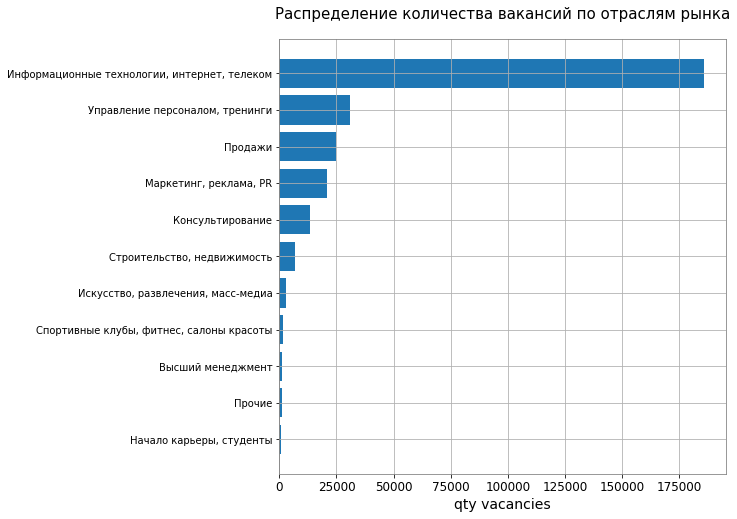

In [39]:
# график рапрделения вакансий по всем отраслям рынка в нашем датасете (ознакомительно, так как в выборке изначальный сдвиг в сторону IT-вакансий)

other = total_prof_area_name_df[total_prof_area_name_df['qty'] < 500]
market_plot =  total_prof_area_name_df[total_prof_area_name_df['qty'] > 500]
market_plot.loc[len(market_plot)] = ['Прочие', other['qty'].sum()]
market_plot = market_plot.sort_values(by='qty')

plt.figure(figsize=(8, 8))
plt.barh(market_plot['name'], market_plot['qty'])

plt.title('Распределение количества вакансий по отраслям рынка', pad=20)
plt.xlabel('qty vacancies')
plt.show()

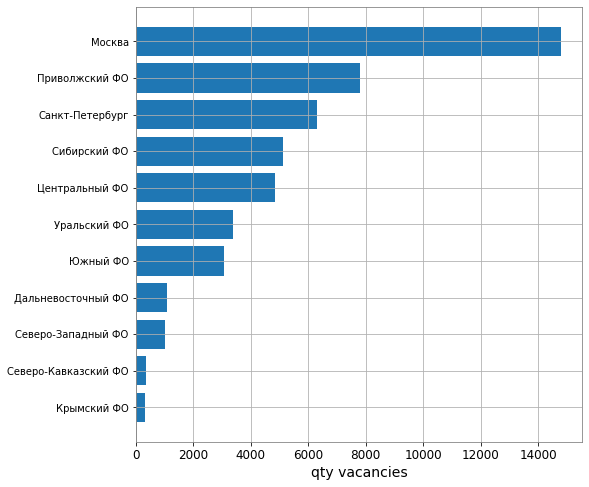

In [40]:
# посмотрим на распределение вакансий в разрезе федеральных округов
# Приволжский ФО обогнал СПб, причем даже если сложить СПб+Северо-Западный ФО

most_popular_dist = data_it['federal_district'].value_counts()

most_popular_dist = pd.DataFrame(most_popular_dist).reset_index()\
                                                    .rename(columns={'index': 'federal_district', 'federal_district': 'qty'})
most_popular_dist['%'] = (most_popular_dist['qty'] * 100 / most_popular_dist['qty'].sum()).round(1)
most_popular_dist = most_popular_dist.sort_values(by='qty')

plt.figure(figsize=(8, 8))
plt.barh(most_popular_dist['federal_district'], most_popular_dist['qty'])
plt.xlabel('qty vacancies')

plt.show()

In [41]:
# посмотрим, какие профессии наиболее популярны в сфере IT.
# Ниже таблица данных на основе колонки specialization. Мы можем взять отсюда самые популярные направления, 
# но не сможем оценить кол-во вакансий, так в одной колонке каждой вакансии указано несколько типов "специализаций"
# Предварительные выводы: самые популярные категории видны в таблице

it_prof_name_df.head(20)

,Total_qty
Инженер,32334
"Программирование, Разработка",24349
Системы управления предприятием (ERP),18222
"Поддержка, Helpdesk",15282
Системный администратор,15207
Web инженер,14408
Web мастер,14378
Интернет,12354
Аналитик,11669
Другое,11381


In [42]:
# посмотрим, какие профессии наиболее популярны в сфере IT на основе тех, которые выделили вручную. Удобнее будет посмотреть это в таблице, так как много категорий.

# Предварительные выводы:  самые большие группы - это программист/разработчик, ИТ-специалист общего профиля, администраторы 1с, системные администраторы, аналитики и т.д.
# Название вакансии дает представление о функционале, но не показывает конкреной направленности (например, язык программирования), это мы увидим в разрезах skills

most_popular_vac = data_it.groupby('vac_general').agg(qty_vac = ('vac_general', 'count')).sort_values(by='qty_vac', ascending=False).round(0)

most_popular_vac = pd.DataFrame(most_popular_vac)
most_popular_vac['%_of_all'] = (most_popular_vac['qty_vac'] * 100 / most_popular_vac['qty_vac'].sum()).round(1)

most_popular_vac[['qty_vac', '%_of_all']]


,qty_vac,%_of_all
vac_general,,
Программист/разработчик,8061,16.8
IT-специалист/технический специалист,5215,10.8
Специалист/администратор 1С,4669,9.7
Руководитель проекта/группы/отдела,4399,9.2
Системный администратор/devops,4156,8.6
Аналитик/Data scientist,4042,8.4
Web-разработчик,2597,5.4
Инженер,2522,5.2
Тестировщик,2469,5.1


Медианная зарплата: 75000


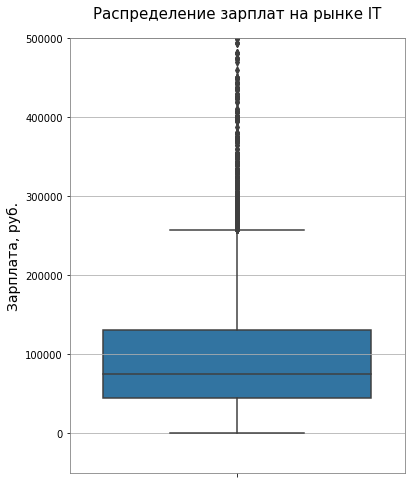

In [43]:
# оценим, как распределяются зарплаты на рынке IT. 
# Предварительные выводы:  распределение очень неравномерное, так как у нас в выборке как топовые должности, так и стажерские позиции, медианная зарплата - 75 тыс.

plt.figure(figsize=(6, 8))
y = data_it['salary_mean']
sns.boxplot(y=y, orient='v')

plt.title('Распределение зарплат на рынке IT', pad=20)
plt.ylim(None, 500000)
plt.ylabel('Зарплата, руб.')

print("Медианная зарплата:", data_it['salary_mean'].quantile(0.5))

plt.show()

In [44]:
# описательная статистика по колонке "зарплата". Видно, что есть сильные выбросы

data_it.salary_mean.describe().round().astype('Int64')

count      21591
mean      100101
std        80695
min           30
25%        45000
50%        75000
75%       130250
max      1015000
Name: salary_mean, dtype: Int64

In [45]:
# уберем 3% минимальных и 3% максимальных значений, чтобы адекватнее оценить средние

q_min = data_it.salary_mean.quantile(0.03)
q_max = data_it.salary_mean.quantile(0.97)
salary_corrected = data_it[(data_it['salary_mean'] > q_min) & (data_it['salary_mean'] < q_max)]

salary_corrected.salary_mean.describe().round().astype('Int64')

count     20012
mean      94130
std       61057
min       16000
25%       45000
50%       75000
75%      125000
max      297000
Name: salary_mean, dtype: Int64

Медианная зарплата: 75000


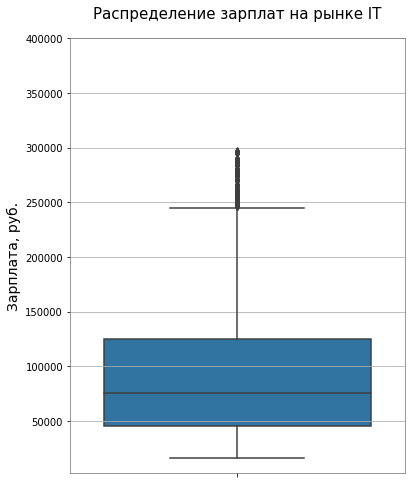

In [46]:
# боксплот скорректированной зарплаты

plt.figure(figsize=(6, 8))
y = salary_corrected['salary_mean']
sns.boxplot(y=y, orient='v')

plt.title('Распределение зарплат на рынке IT', pad=20)
plt.ylim(None, 400000)
plt.ylabel('Зарплата, руб.')

print("Медианная зарплата:", data_it['salary_mean'].quantile(0.5))

plt.show()

In [48]:
# распределение зарплат по специальности
# Предварительные выводы:  самые высокие зарплаты у scram-мастеров, которых тоже можно приравнять к руководителям проекта,  
# архитекторы обеспечивают базу всей IT-сферы компании, алминистраторы SAP, разработчики игр и другие разработчикии. 
# Руководители в среднем получают ниже, чем хайповые специалисты
# НО! Надо иметь ввиду размер выборки(количетво вакансий srum-мастеров единицы, в то время как других вакансий - тысячи),
# из-за этого может быть сильный сдвиг среднего

mean_salary_corrected = salary_corrected.groupby('vac_general')['salary_mean'].mean().sort_values(ascending=False).round().astype('Int64')
mean_salary_corrected

vac_general
Scrum-мастер                                 147571
Архитектор                                   143560
Game development                             142833
Специалист/администратор SAP                 142273
Программист/разработчик                      126639
Тестировщик                                  125599
Web-разработчик                              124122
Руководитель проекта/группы/отдела           122333
Методолог                                    112987
Специалист/администратор 1С                  110219
Администратор баз данных                     105884
Аналитик/Data scientist                      101916
Менеджер продукта/проекта                    100697
Технический писатель                          89111
Менеджер по продажам                          83397
Администратор, прочие направления             83189
Специалист по информационной безопасности     80315
Художник компьютерной графики/аниматор        78433
Системный администратор/devops                73221


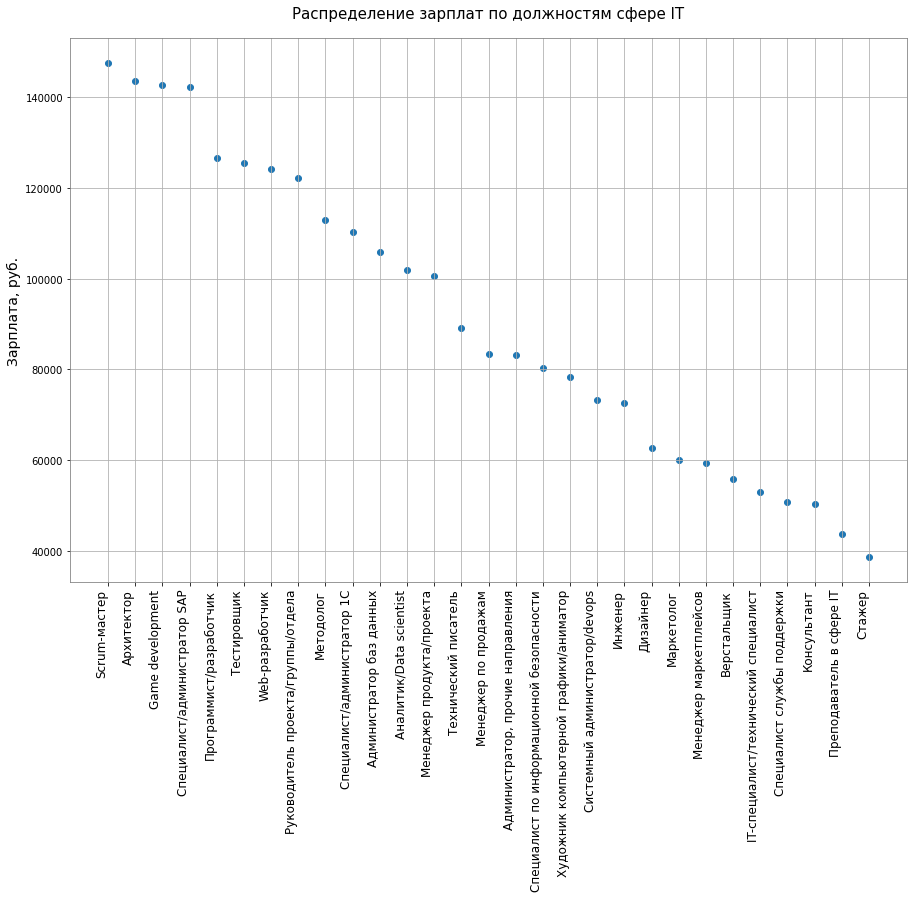

In [49]:
# график распределения зарплат в зависимости от специальности

plt.figure(figsize=(15, 10))


plt.scatter(mean_salary_corrected.index, mean_salary_corrected.values)

plt.xticks(rotation=90, ha = 'right')
plt.ylabel('Зарплата, руб.')
plt.title('Распределение зарплат по должностям сфере IT', pad=20)

plt.show()

In [50]:
# посмотрим на распредение зарплат в разрезе самых популярных вакансий
# !!! тут важно иметь ввиду, что зарплат нет на более чем половину вакансиям. В отдельном столбце видно, какой процент зарплат по каждой вакансии отсутствует

most_popular_vac = data_it.groupby('vac_general').agg(qty_vac = ('vac_general', 'count'), mean_salary= ('salary_mean', 'mean'))\
                                                  .sort_values(by='qty_vac', ascending=False).round(0)
most_popular_vac = pd.DataFrame(most_popular_vac).reset_index()\
                                                  .rename(columns={'index': 'vac_general'})
qty_null_salary = data_it[data_it['salary_mean'].isna()].groupby('vac_general')['employer'].count()
most_popular_vac = most_popular_vac.merge(qty_null_salary, how='left', on='vac_general')\
                                    .rename(columns={'employer': 'qty_null_salary'})
most_popular_vac['%_null_salary'] = (most_popular_vac['qty_null_salary'] / most_popular_vac['qty_vac'] * 100).round(1)

total_salary_null = data_it['salary_mean'].isna().sum()
print(f'Нет зарплат по всему датасету data_it по {total_salary_null} вакансиям')
most_popular_vac

Нет зарплат по всему датасету data_it по 26483 вакансиям


,vac_general,qty_vac,mean_salary,qty_null_salary,%_null_salary
0,Программист/разработчик,8061,144610.0,4347,53.9
1,IT-специалист/технический специалист,5215,47306.0,1838,35.2
2,Специалист/администратор 1С,4669,110722.0,1982,42.5
3,Руководитель проекта/группы/отдела,4399,143369.0,2875,65.4
4,Системный администратор/devops,4156,79828.0,1850,44.5
5,Аналитик/Data scientist,4042,109702.0,2924,72.3
6,Web-разработчик,2597,128664.0,1475,56.8
7,Инженер,2522,83780.0,1499,59.4
8,Тестировщик,2469,136594.0,1956,79.2
9,Менеджер продукта/проекта,2467,110436.0,1461,59.2


In [52]:
# посмотрим на наиболее запрашиваемые навыки среди вакансий сферы IT
# Предварительные выводы: 
# самые запрашиваемые hard skills: SQL, 1С, Linux, Git, Python, Английский язык, управление проектами и т.д.
# - то есть это базовые навыки для работников IT-сферы, можно взять этот факт на вооружение
# самые запрашиваемые soft skills: Аналитические способности, деловая коммуникация, 
# работа в команде и т.д. - тоже можно использовать при составлении курсов

grouped_skills_df.head(15)


,skill_general,qty,%qty
0,1C,14068,7.5
1,SQL,13203,7.0
2,"Аналитические способности, работа с инфо",7387,3.9
3,Деловая коммуникация,7242,3.8
4,Linux/Bash,5713,3.0
5,Git,4534,2.4
6,Управление проектами,4201,2.2
7,"Работа в команде, коммуникабельность",4083,2.2
8,Английский язык,3700,2.0
9,Администрирование,3368,1.8


In [56]:
# самые активные работодатели. 
# Предвариательные выводы: лидер по найму персонала - Яндекс, затем в первую 10ку попали компании областей финтеха, ресурсодобывающие, маркетплейсы, телеком

active_employers = data_it.groupby('employer', as_index=False).agg(qty=('employer', 'count')).sort_values(by='qty', ascending=False).reset_index().drop('index', axis=1)
active_employers['%qty'] = (active_employers['qty'] / active_employers['qty'].sum() * 100).round(2)

active_employers.head(15)

,employer,qty,%qty
0,Яндекс,1846,3.84
1,Газпром нефть,513,1.07
2,Сбербанк,505,1.05
3,Тинькофф,454,0.94
4,Ростелеком,325,0.68
5,МТС,321,0.67
6,ИК СИБИНТЕК,317,0.66
7,Ozon,261,0.54
8,VK,234,0.49
9,Первый Бит,201,0.42


In [57]:
# распределение вакансий по типам рабочих графиков 
# Предварительные выводы: БОльшая часть вакансий подразумевает полный рабочий день

schedules = data_it.groupby('schedule', as_index=False).agg(qty=('vac_general', 'count')).sort_values(by='qty', ascending=False)
schedules['%_of_all'] = (schedules['qty'] * 100 / schedules['qty'].sum()).round()
schedules

,schedule,qty,%_of_all
2,Полный день,35257,73.0
4,Удаленная работа,9909,21.0
1,Гибкий график,1989,4.0
3,Сменный график,803,2.0
0,Вахтовый метод,116,0.0


In [58]:
# распределение вакансий по опыту работы. 
# Предвариательные выводы: Интересный факт, что для боблее чем 50% вакансий требуется опыт всего 1-3 года

experiense_rate = data_it.groupby('experience', as_index=False).agg(qty=('vac_general', 'count')).sort_values(by='qty', ascending=False)
experiense_rate['%_of_all'] = (experiense_rate['qty'] / experiense_rate['qty'].sum() * 100).round(2)
experiense_rate

,experience,qty,%_of_all
2,От 1 года до 3 лет,25067,52.14
3,От 3 до 6 лет,15853,32.98
1,Нет опыта,5564,11.57
0,Более 6 лет,1590,3.31


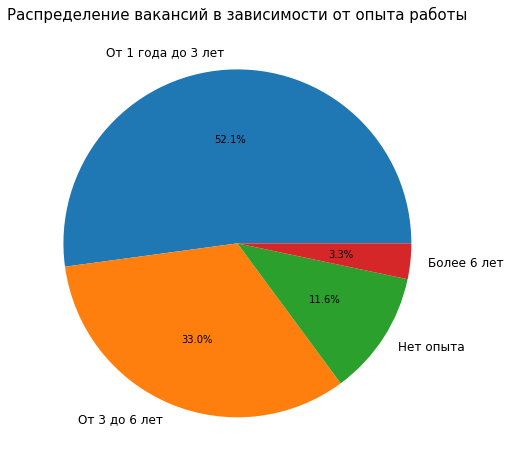

In [59]:
# диаграмма распределения вакансий по опыту работы

plt.figure(figsize=(8, 8))

plt.pie(experiense_rate['qty'], labels=experiense_rate['experience'], autopct='%1.1f%%')
plt.title('Распределение вакансий в зависимости от опыта работы')

plt.show()

In [61]:
# средние зарплаты в зависисмости от опыта работы
# Предвариательные выводы: что логично - тут прямая корреляция, проверим это в блоке стат. анализа

salary_expert = salary_corrected.groupby('experience', as_index=False)['salary_mean'].mean().sort_values(by='salary_mean', ascending=False).round()
salary_expert

,experience,salary_mean
0,Более 6 лет,147293.0
3,От 3 до 6 лет,134421.0
2,От 1 года до 3 лет,85525.0
1,Нет опыта,47192.0


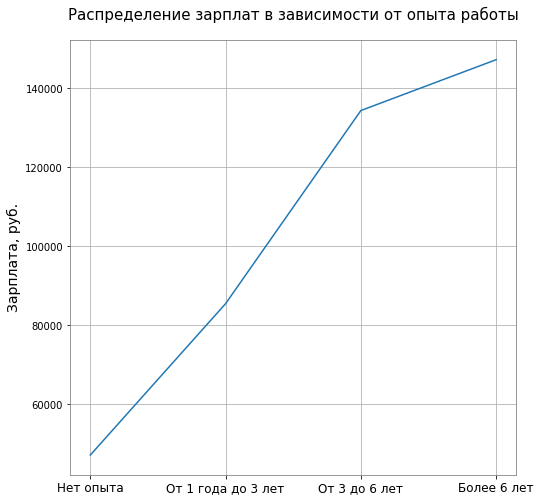

In [62]:
# график распределения зарплат в зависимости от опыта работы

plt.figure(figsize=(8, 8))

x = salary_expert['experience'].tolist()[::-1]
y = salary_expert['salary_mean'].tolist()[::-1]
plt.plot(x, y)
plt.title('Распределение зарплат в зависимости от опыта работы', pad=20)
plt.ylabel('Зарплата, руб.')

plt.show()

# Статистический анализ

In [109]:
from itertools import combinations

import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [65]:
# убираем колонки, не нужные в статанализе

data_it_stat = data_it.drop(['name', 'employer', 'region', 'area_name', 'prof_name'], axis=1)

In [66]:
data_it_stat.head(3)

,salary_mean,schedule,experience,federal_district,vac_general,SQL,1C,"Аналитические способности, работа с инфо",Деловая коммуникация,Linux/Bash,...,Python и библиотеки,AdobePhotoshop/ Illustrator,JavaScript,Тестирование,Информационная безопасность,HTML,Java,CSS,Windows,Jira
0,<NA>,Удаленная работа,Нет опыта,Южный ФО,Тестировщик,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,37500,Полный день,От 1 года до 3 лет,Южный ФО,Тестировщик,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,<NA>,Полный день,От 3 до 6 лет,Южный ФО,Тестировщик,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


### Анализ

In [67]:
# оценим типы данных, у нас только одна колонка вещественного типа, все остальные категориальные, не считая колонок OHE -  по сути, это тоже категории

data_it_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48074 entries, 0 to 69655
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   salary_mean                               21591 non-null  Int64 
 1   schedule                                  48074 non-null  object
 2   experience                                48074 non-null  object
 3   federal_district                          48074 non-null  object
 4   vac_general                               48074 non-null  object
 5   SQL                                       48074 non-null  int64 
 6   1C                                        48074 non-null  int64 
 7   Аналитические способности, работа с инфо  48074 non-null  int64 
 8   Деловая коммуникация                      48074 non-null  int64 
 9   Linux/Bash                                48074 non-null  int64 
 10  GIT                                       4807

In [ ]:

# убрала этот пункт, так как он приводил к сильному скосу в данных
# заполним пропущенние значения зарплат средним по группе, с одинаковыми признаками: 'experience', 'federal_district', 'vac_general', оставлиеся 280 значений удалим

# lst = ['experience', 'federal_district', 'vac_general']
# grouped_means = data_it_stat.groupby(lst)['salary_mean'].transform('median').astype('Int64')
# data_it_stat['salary_mean'] = data_it_stat['salary_mean'].fillna(grouped_means)

# data_it_stat = data_it_stat[data_it_stat['salary_mean'].notna()]

In [68]:
# в данных по зарплате очень много nan, придется их все удалить, чтобы не внеcти смещение в данные

data_it_stat['salary_mean'].isna().sum()

26483

In [69]:
# УДАЛИМ все наны в зп

data_it_stat = data_it_stat[data_it_stat['salary_mean'].notna()]

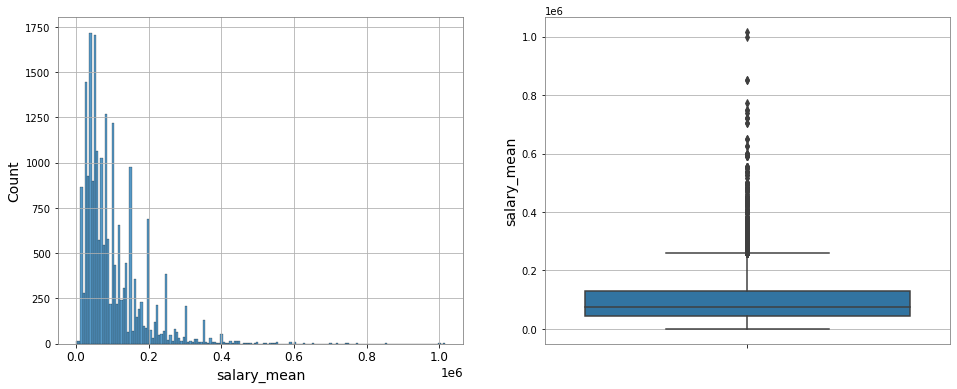

In [70]:
# посмотрим на распределение средней заработной платы
# мы видим, что распределение очень сильно скошено вправо и есть сильные выбросы

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 6)

sns.histplot(data_it_stat['salary_mean'], ax=ax[0])
sns.boxplot(y='salary_mean', data=data_it_stat, ax=ax[1], orient='h')
plt.show()

In [71]:
# уберем по 3% крайних значений слева и справа

q03, q97 = np.quantile(data_it_stat['salary_mean'], 0.03), np.quantile(data_it_stat['salary_mean'], 0.97)
data_it_stat = data_it_stat[(data_it_stat['salary_mean'] < q97) & (data_it_stat['salary_mean'] > q03)]

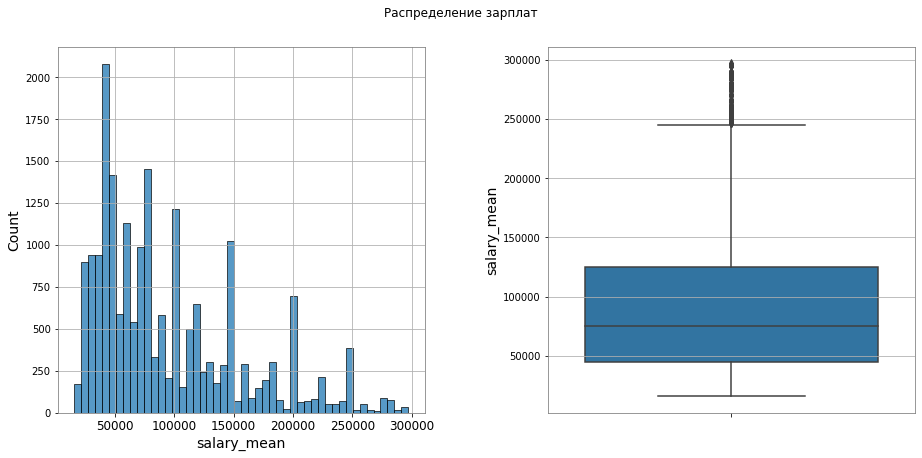

In [72]:
# снова нарисуем графики на скорректировнных данных
# визуально видно, что данные распределены не нормально, но в качестве эксперимента, проверим эту гипотеза тремя способами:
# оценкой коэффициентов симметрии, эксцесса, Тестом Агостино, тестом Шапиро-Уилка

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 7)

plt.suptitle('Распределение зарплат')
sns.histplot(data_it_stat['salary_mean'], ax=ax[0])
sns.boxplot(y='salary_mean', data=data_it_stat, ax=ax[1], orient='v')


plt.tight_layout(5)
plt.show()

In [73]:
# у распределения сильное смещение  и слишком маленький коэфф. эксцесса

s = data_it_stat['salary_mean'].skew()
k = data_it_stat['salary_mean'].kurtosis()
print(f'Смещение {s}')
print(f'Эксцесс {k}')

Смещение 1.0980578890129173
Эксцесс 0.49804955117221716


In [75]:
# Н0: данные по средней зарплате имеют нормальное распределение 
# Н1: данные по средней зарплате имеют не нормальное распределение 
# Тип данных: количественные
# Метод: тест д'Агостино
# Результат: отвергаем H0 о нормальности данных, т.к. p < alpha
# Вывод: принимаем гипотезу H1, что данные распределены ненормально

scipy.stats.normaltest(data_it_stat['salary_mean'])

NormaltestResult(statistic=2855.122354563748, pvalue=0.0)

In [74]:
# Н0: данные по средней зарплате имеют нормальное распределение 
# Н1: данные по средней зарплате имеют не нормальное распределение 
# Тип данных: количественные
# Метод: тест Шапиро-Вилка
# Результат: отвергаем H0 о нормальности данных, т.к. p < alpha
# Вывод: принимаем гипотезу Н1 о том, что данные распределены ненормально

scipy.stats.shapiro(data_it_stat['salary_mean'])

ShapiroResult(statistic=0.8875364065170288, pvalue=0.0)

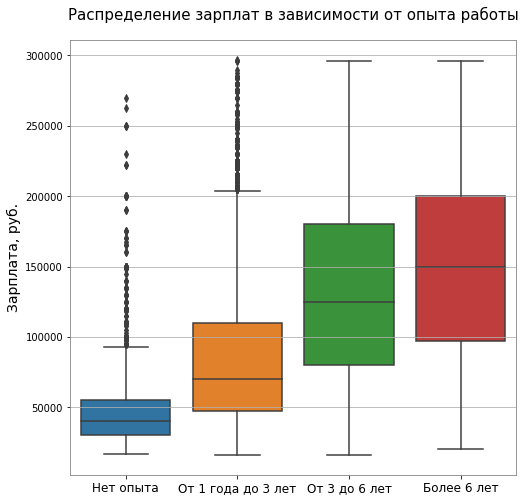

In [79]:
# боксплот распределения зарплат в зависимости от опыта работы
# предположим, что общее распределение зарплат смещается из-за разного распределения внутри групп по опыту работы.
# проверим эту гипотезу

plt.figure(figsize=(8, 8))

order = data_it_stat.groupby('experience')['salary_mean'].median().sort_values().index
sns.boxplot(data_it_stat['experience'], data_it_stat['salary_mean'], order=order)

plt.title('Распределение зарплат в зависимости от опыта работы', pad=20)
plt.ylabel('Зарплата, руб.')
plt.xlabel('')

plt.show()

In [80]:
# Н0: данные по средней зарплате имеют нормальное распределение  по группам опыта работы
# Н1: данные по средней зарплате имеют не нормальное распределение  по группам опыта работы
# Тип данных: количественные
# Метод: тест Шапиро-Вилка
# Результат: отвергаем H0 о нормальности распрелеления, т.к. p < alpha
# Вывод:  принимаем гипотезу Н1 о том, что данные распределены ненормально во всех группах, даже где нет выбросов

experience_groups = []
for col in data_it_stat['experience'].unique():
  group = data_it_stat[data_it_stat['experience'] == col]['salary_mean'].values
  experience_groups.append(group)
  shapiro_test = scipy.stats.shapiro(group)
  print(f'{col}:           {shapiro_test}')

От 1 года до 3 лет:           ShapiroResult(statistic=0.8763870000839233, pvalue=0.0)
Нет опыта:           ShapiroResult(statistic=0.7566227316856384, pvalue=0.0)
От 3 до 6 лет:           ShapiroResult(statistic=0.9588183164596558, pvalue=1.865674336422685e-36)
Более 6 лет:           ShapiroResult(statistic=0.9681874513626099, pvalue=2.4522467612086984e-08)


In [81]:
# Н0: данные не имеют статзначимых различий в распределении зарплат групп по опыту работы
# Н1: данные имеют статзначимые различия в распределении зарплат групп по опыту работы
# Тип данных: количественные
# Метод: критерий Краскела-Уолиса
# Результат: отвергаем H0 об отсутствии различиях выборок, т.к. p < alpha
# Вывод: принимаем Н1 о том, что данные имеют статзначимые различия

scipy.stats.mstats.kruskalwallis(*experience_groups)

KruskalResult(statistic=5473.64738294603, pvalue=0.0)

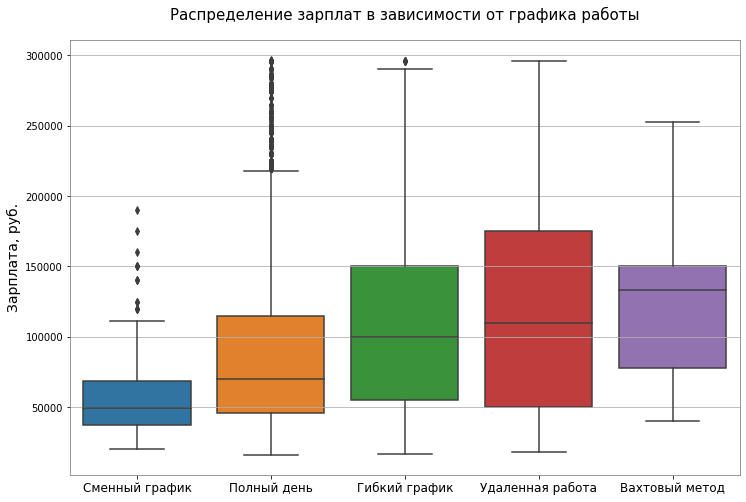

In [82]:
# Оценим, как распределяются зарплаты в зависимости от графика работы

plt.figure(figsize=(12, 8))

order = data_it_stat.groupby('schedule')['salary_mean'].median().sort_values().index
sns.boxplot(data_it_stat['schedule'], data_it_stat['salary_mean'], order=order)

plt.title('Распределение зарплат в зависимости от графика работы', pad=20)
plt.ylabel('Зарплата, руб.')
plt.xlabel('')

plt.show()

In [84]:
# Н0: данные по средней зарплате имеют нормальное распределение по группам графика работы
# Н1: данные по средней зарплате имеют не нормальное распределение по группам графика работы
# Тип данных: количественные
# Метод: тест Шапиро-Вилка
# Результат: отвергаем H0 о нормальности распределения, т.к. p < alpha
# Вывод: принимаем Н1 о том, что данные распределены ненормально во всех группах, кроме 'Вахтовый метода'

schedule_groups = []
for col in data_it_stat['schedule'].unique():
  group = data_it_stat[data_it_stat['schedule'] == col]['salary_mean'].values
  schedule_groups.append(group)
  shapiro_test = scipy.stats.shapiro(group)
  print(f'{col}:           {shapiro_test}')

Полный день:           ShapiroResult(statistic=0.8758007884025574, pvalue=0.0)
Гибкий график:           ShapiroResult(statistic=0.9346480369567871, pvalue=4.897940555101655e-17)
Удаленная работа:           ShapiroResult(statistic=0.9333357214927673, pvalue=1.1570301416071116e-38)
Сменный график:           ShapiroResult(statistic=0.8605253100395203, pvalue=2.5526284793439258e-20)
Вахтовый метод:           ShapiroResult(statistic=0.954050600528717, pvalue=0.07239843159914017)


In [85]:
# Н0: данные не имеют статзначимых различий в распределении зарплат групп по графику работы
# Н1: данные имеют статзначимые различия в распределении зарплат групп по графику работы
# Тип данных: количественные
# Метод: критерий Краскела-Уолиса
# Результат: отвергаем H0 об отсутствии статзначимых различий выборок, т.к. p < alpha
# Вывод: принимаем Н1 о том, что данные имеют статзначимые различия

scipy.stats.mstats.kruskalwallis(*schedule_groups)

KruskalResult(statistic=705.6289454944881, pvalue=2.105702166558784e-151)

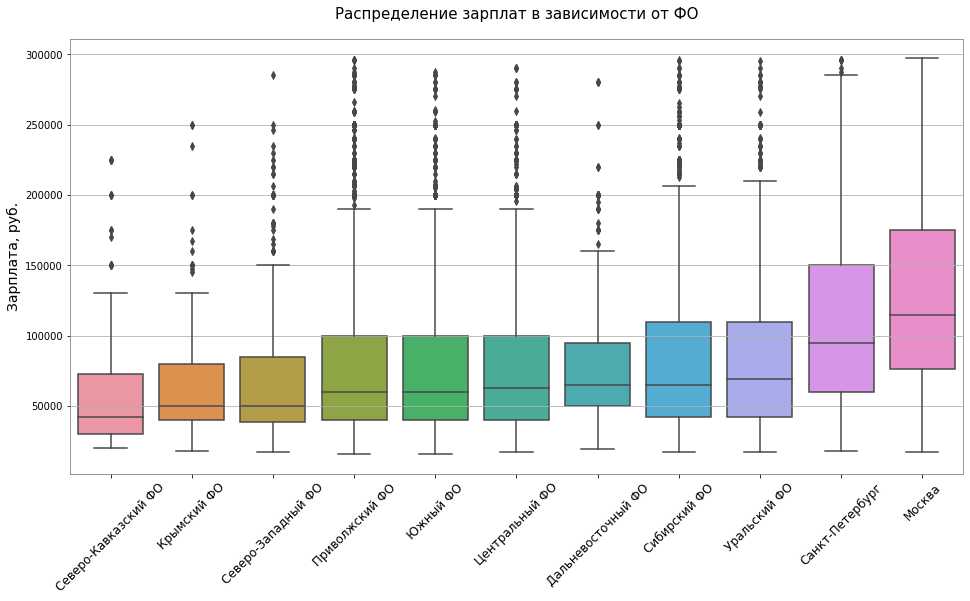

In [86]:
# посмотрим, зависисит ли зарплата от географии компании 

plt.figure(figsize=(16, 8))

order = data_it_stat.groupby('federal_district')['salary_mean'].median().sort_values().index
sns.boxplot(data_it_stat['federal_district'], data_it_stat['salary_mean'], order=order)

plt.title('Распределение зарплат в зависимости от ФО', pad=20)
plt.ylabel('Зарплата, руб.')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Н0: распределения зарплат в зависимости от ФО имеют нормальное распределение по группам графика работы
# Н1: распределения зарплат в зависимости от ФО имеют не нормальное распределение по группам графика работы
# Тип данных: количественные
# Метод: тест Шапиро-Вилка
# Результат: отвергаем H0 о нормальности данных, т.к. p < alpha
# Вывод: принимаем Н1 о том, что распределения зарплат в зависимости от ФО не нормальны

federal_groups = []
for col in data_it_stat['federal_district'].unique():
  group = data_it_stat[data_it_stat['federal_district'] == col]['salary_mean'].values
  federal_groups.append(group)
  shapiro_test = scipy.stats.shapiro(group)
  print(f'{col}:           {shapiro_test}')

Южный ФО:           ShapiroResult(statistic=0.8372089862823486, pvalue=5.699614468864246e-38)
Дальневосточный ФО:           ShapiroResult(statistic=0.8536799550056458, pvalue=3.1427536888183e-23)
Центральный ФО:           ShapiroResult(statistic=0.8690894842147827, pvalue=8.001414231294705e-43)
Сибирский ФО:           ShapiroResult(statistic=0.8620196580886841, pvalue=6.0395963812399616e-43)
Приволжский ФО:           ShapiroResult(statistic=0.8338214755058289, pvalue=0.0)
Северо-Кавказский ФО:           ShapiroResult(statistic=0.7441568374633789, pvalue=3.9488994465531315e-18)
Северо-Западный ФО:           ShapiroResult(statistic=0.800106406211853, pvalue=3.3886134016160437e-25)
Крымский ФО:           ShapiroResult(statistic=0.7909717559814453, pvalue=5.4734388137307743e-14)
Москва:           ShapiroResult(statistic=0.9472939968109131, pvalue=8.929664826318048e-37)
Уральский ФО:           ShapiroResult(statistic=0.8728006482124329, pvalue=1.9560180079934785e-35)
Санкт-Петербург:       

In [ ]:
# Н0: данные не имеют статзначимых различий в распределении зарплат групп по ФО
# Н1: данные имеют статзначимые различия в распределении зарплат групп по ФО
# Тип данных: количественные
# Метод: критерий Краскела-Уолиса
# Результат: отвергаем H0 об отсутствии статзначимых различий, т.к. p < alpha
# Вывод: принимаем Н1 о том, что данные имеют статзначимые различия

scipy.stats.mstats.kruskalwallis(*federal_groups)

KruskalResult(statistic=2652.9426681398722, pvalue=0.0)

In [89]:
# оценим зависимости попарно среди ФО, чтобы объединить их в группы

# Н0: данные не имеют статзначимых различий в распределении зарплат групп по ФО при попарном сравнении
# Н1: данные имеют статзначимые различия в распределении зарплат групп по ФО при попарном сравнении
# Тип данных: количественные
# Метод: критерий Манна-Уитни
# Результат: отвергаем H0 об отсутствии статзначимых различий для всех округов, кроме двух пар, т.к. p < alpha
# Вывод: данные не имеют статзначимхе различий для федеральных округов Южный-Уральский, Центральный-Сибирский 
# Итог: для анализа зарплат можно попаро объединить эти округа

pairs = combinations(data_it_stat['federal_district'].unique(), 2)
for i, j in pairs:
  a = data_it_stat['federal_district'] == i
  b  = data_it_stat['federal_district'] == j
  test = scipy.stats.mstats.mannwhitneyu(a, b)
  if test[1] > 0.05:
    print(i, j, test)

Южный ФО Уральский ФО MannwhitneyuResult(statistic=199259484.0, pvalue=0.07764753897426735)
Центральный ФО Сибирский ФО MannwhitneyuResult(statistic=199069370.0, pvalue=0.08373583301783537)


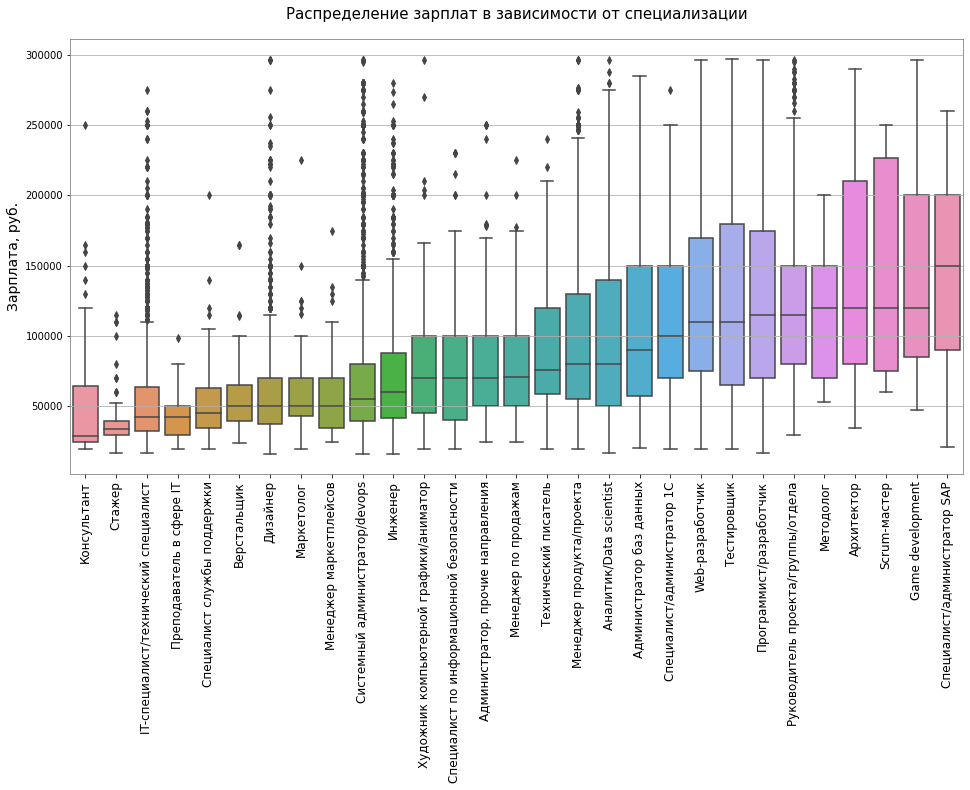

In [90]:
# посмотрим, как зависит зарплата от специализации 

plt.figure(figsize=(16, 8))

order = data_it_stat.groupby('vac_general')['salary_mean'].median().sort_values().index
sns.boxplot(data_it_stat['vac_general'], data_it_stat['salary_mean'], order=order)

plt.title('Распределение зарплат в зависимости от специализации', pad=20)
plt.ylabel('Зарплата, руб.')
plt.xlabel('')
plt.xticks(rotation=90)
plt.show()

In [92]:
# Н0: с разделением на группы по специализациям, распределения нормальны
# Н1: с разделением на группы по специализациям, распределения не нормальны
# Тип данных: количественные
# Метод: тест Шапиро-Вилка
# Результат: отвергаем H0 о нормальности данных, т.к. p < alpha
# Вывод: распределения зарплат в группах в зависимости от специализаций не нормальны, кроме специальностей 'Специалист/администратор SAP', 'Scrum-мастер'

spec_groups = []
for col in data_it_stat['vac_general'].unique():
  group = data_it_stat[data_it_stat['vac_general'] == col]['salary_mean'].values
  spec_groups.append(group)
  shapiro_test = scipy.stats.shapiro(group)
  print(f'{col}:           {shapiro_test}')

Тестировщик:           ShapiroResult(statistic=0.9385092258453369, pvalue=2.873038449941606e-13)
IT-специалист/технический специалист:           ShapiroResult(statistic=0.7645843029022217, pvalue=0.0)
Аналитик/Data scientist:           ShapiroResult(statistic=0.9012569189071655, pvalue=7.915144977207072e-26)
Руководитель проекта/группы/отдела:           ShapiroResult(statistic=0.9525747299194336, pvalue=6.873319167309436e-21)
Инженер:           ShapiroResult(statistic=0.8108338713645935, pvalue=1.8865658711876622e-32)
Дизайнер:           ShapiroResult(statistic=0.7524805068969727, pvalue=1.257222633163278e-35)
Менеджер продукта/проекта:           ShapiroResult(statistic=0.8827482461929321, pvalue=1.8873708239334612e-26)
Системный администратор/devops:           ShapiroResult(statistic=0.7610231637954712, pvalue=0.0)
Администратор баз данных:           ShapiroResult(statistic=0.901332676410675, pvalue=6.285067133404709e-09)
Специалист/администратор 1С:           ShapiroResult(statistic=

In [93]:
# Н0: данные не имеют статзначимых различий в распределении зарплат групп по специализации
# Н1: данные имеют статзначимые различия в распределении зарплат групп по специализации
# Тип данных: количественные
# Метод: критерий Краскела-Уолиса
# Результат: отвергаем H0 об отсутствии статзначимых различий, т.к. p < alpha
# Вывод: данные имеют статзначимые различия

scipy.stats.mstats.kruskalwallis(*spec_groups)

KruskalResult(statistic=5469.16823217728, pvalue=0.0)

In [94]:
# датасет, где вакансии, которых < 500 заменены на "другое", а также три специальности ['Инженер', 'Менеджер продукта/проекта', 'Дизайнер']

vac_count  = data_it_stat.groupby('vac_general')['vac_general'].count()
other = vac_count[vac_count < 500].index.to_list()
other += ['Инженер', 'Менеджер продукта/проекта', 'Дизайнер']
data_it_stat2 = data_it_stat.copy()
data_it_stat2.loc[data_it_stat2['vac_general'].isin(other), 'vac_general'] = 'Другие'
other

['Game development',
 'Scrum-мастер',
 'Администратор баз данных',
 'Администратор, прочие направления',
 'Архитектор',
 'Верстальщик',
 'Консультант',
 'Маркетолог',
 'Менеджер маркетплейсов',
 'Менеджер по продажам',
 'Методолог',
 'Преподаватель в сфере IT',
 'Специалист по информационной безопасности',
 'Специалист службы поддержки',
 'Специалист/администратор SAP',
 'Стажер',
 'Тестировщик',
 'Технический писатель',
 'Художник компьютерной графики/аниматор',
 'Инженер',
 'Менеджер продукта/проекта',
 'Дизайнер']

In [96]:
# оценим зависимости попарно среди специальностей, чтобы объединить их в группы при необходимости

# Н0: данные не имеют статзначимых различий в распределении зарплат групп по специальности при попарном сравнении
# Н1: данные имеют статзначимые различия в распределении зарплат групп по специальности при попарном сравнении
# Тип данных: количественные
# Метод: критерий Манна-Уитни
# Результат: отвергаем H0 об отсутствии статзначимых различий т.к. p < alpha
# Вывод: данные в объединенных группах не имеют статзначимых различий

from itertools import combinations

pairs = combinations(data_it_stat2['vac_general'].unique(), 2)
to_delete = []
for i, j in pairs:
  
  a = data_it_stat2['vac_general'] == i
  b  = data_it_stat2['vac_general'] == j
  test = scipy.stats.mstats.mannwhitneyu(a, b)
  if test[1] > 0.05:
    to_delete.append(i)
    print(f'{i} - {j}: {test[1]}')

In [98]:
# Оценим, как распределяются рабочие графики в зависимости от опыта работы

sched_exp = pd.crosstab(data_it_stat['schedule'], data_it_stat['experience'])
sched_exp

experience,Более 6 лет,Нет опыта,От 1 года до 3 лет,От 3 до 6 лет
schedule,,,,
Вахтовый метод,1,0,23,21
Гибкий график,11,139,382,175
Полный день,377,2030,8557,3910
Сменный график,0,147,303,33
Удаленная работа,63,744,1885,1211


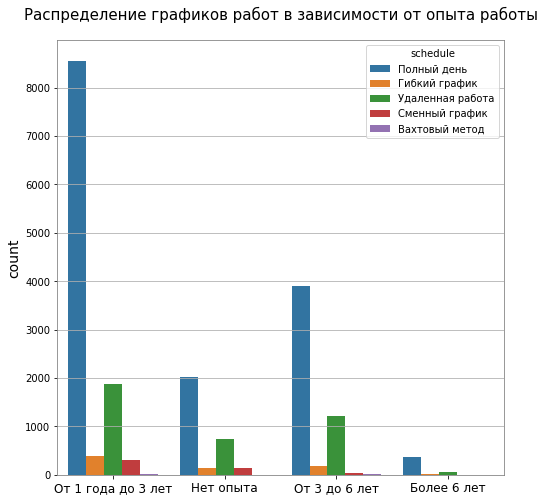

In [100]:
# Гистограмма зависимости графика работы от опыта работы

plt.figure(figsize=(8, 8))
sns.countplot(x=data_it_stat['experience'], hue=data_it_stat['schedule'])

plt.title('Распределение графиков работ в зависимости от опыта работы', pad=20)
plt.xlabel('')

plt.show()

In [101]:
# Н0: выборки по опыту работы и типу занятости независимы
# Н1: выборки по опыту работы и типу занятости зависимы
# Гипотеза: выборки по опыту работы и типу занятости независимы
# Тип данных: качественные
# Метод: критерий Хи-квадрат
# Результат: отвергаем H0 о независимости выборок т.к. p < alpha
# Вывод: принимаем Н1 о том, что данные выборки зависимы т.о. требования к опыту работы и графику работы имеют некую связь

chi2, prob, df, expected = scipy.stats.chi2_contingency(sched_exp)
output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"
 
print(output.format( chi2, df, prob))

test Statistics: 334.81668061511766
degrees of freedom: 12
p-value: 2.2298377172214297e-64



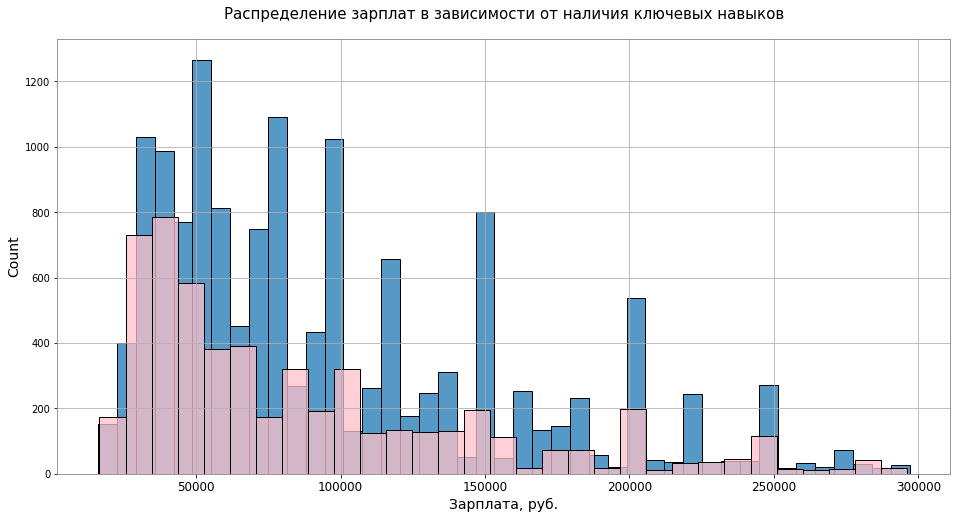

In [104]:
# Оценим зависимость заработной платы от наличия в требованиях к вакансии самых популярных навыков

top_skills = ['SQL', '1C', 'Аналитические способности, работа с инфо',
       'Деловая коммуникация', 'Linux/Bash', 'GIT', 'Управление проектами',
       'Работа в команде, коммуникабельность', 'Английский язык',
       'Администрирование', 'Python и библиотеки',
       'AdobePhotoshop/ Illustrator', 'JavaScript', 'Тестирование',
       'Информационная безопасность', 'HTML', 'Java', 'CSS', 'Windows']

data_it_top_skills = data_it_stat[data_it_stat[top_skills].sum(axis=1) > 0]
data_it_another_skills = data_it_stat[data_it_stat[top_skills].sum(axis=1) == 0]

plt.figure(figsize=(16, 8))

sns.histplot(x='salary_mean', data= data_it_top_skills)
sns.histplot(x='salary_mean', data= data_it_another_skills, color='pink')

plt.title('Распределение зарплат в зависимости от наличия ключевых навыков', pad=20)
plt.xlabel('Зарплата, руб.')
# plt.xlabel('')

plt.show()

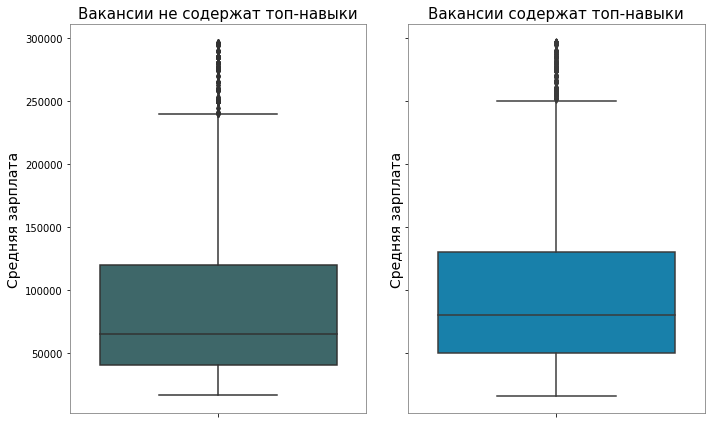

In [105]:
# боксплоты зависимости заработной платы от наличия в требованиях к вакансии самых популярных навыков

fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(10, 6)

sns.boxplot(y='salary_mean', data= data_it_another_skills, color='#376D70', ax=ax[0])
sns.boxplot(y='salary_mean', data= data_it_top_skills, color='#008AC2', ax=ax[1])

ax[0].set_title(f'Вакансии не содержат топ-навыки', fontsize=15)
ax[1].set_title(f'Вакансии содержат топ-навыки', fontsize=15)

ax[0].set_ylabel('Средняя зарплата')
ax[1].set_ylabel('Средняя зарплата')
ax[0].grid(False)
ax[1].grid(False)
plt.tight_layout()
plt.show()

In [106]:
# Н0: данные не имеют статзначимых различий в распределении зарплат в засисимости от наличия топ-навыков
# Н1: данные имеют статзначимые различия в распределении зарплат в засисимости от наличия топ-навыков
# Тип данных: количественные
# Метод: критерий Манна-Уитни
# Результат: отвергаем H0 об отсутствии статзначимых различий, т.к. p < alpha
# Вывод: данные имеют статзначимые различия, т.е. уровень зарплаты зависит от наличия хотя бы одного их ключевых навыков

a = np.array(data_it_top_skills['salary_mean'])
b = np.array(data_it_another_skills['salary_mean'])

scipy.stats.mstats.mannwhitneyu(a, b)

MannwhitneyuResult(statistic=35005118.5, pvalue=3.4427091213346644e-47)

In [108]:
#УДАЛИТЬ
#  оценим зависимости попарно навыки, чтобы в дальнейшем объединить их в группы

# Н0: данные не имеют статзначимых различий в распределении зарплат групп по навыку при попарном сравнении
# Н1: данные имеют статзначимые различия в распределении зарплат групп по навыку при попарном сравнении
# Тип данных: количественные
# Метод: критерий Манна-Уитни
# Результат: отвергаем H0 об отсутствии статзначимых различий т.к. p < alpha
# Вывод: часть данных не имеет статзначимых различий,  а часть пар имеет

from itertools import combinations

pairs = combinations(top_skills, 2)
for i, j in pairs:
  a = data_it_stat[i]
  b  = data_it_stat[j]
  test = scipy.stats.mstats.mannwhitneyu(a, b)
  if test[1] > 0.05:
    print(f'{i} - {j}:     {test[1]}')

Деловая коммуникация - Работа в команде, коммуникабельность:     0.9534699743529931
GIT - Java:     0.27501131718803784
Управление проектами - Администрирование:     0.09745363047568938
Управление проектами - Windows:     0.5642106668474278
Английский язык - AdobePhotoshop/ Illustrator:     0.22389476948714437
Английский язык - HTML:     0.7320630923755302
Администрирование - Windows:     0.27976766961880506
Python и библиотеки - Информационная безопасность:     0.22479820967404884
AdobePhotoshop/ Illustrator - HTML:     0.119109316367756


### Краткие выводы по блоку





## Построение модели регрессии

Используем модель линейной регрессии для предсказания заработной платы в зависимости от опыта работы, названия вакансии, ФО, требуемых навыков, чтобы по полученным коэффициентам понять, какие признаки наиболее сильно влияют на уровень зарплаты. 
Это будет говорить о том, что навык наиболее востребован в образовательных программах.

In [204]:
# сформируем датасет

data_it_reg = data_it_stat.copy()
# data_it_reg = data_it_stat[['vac_general', 'salary_mean']].copy()

In [205]:
# удаляем, так как модель покажет, что они коллинеарны
# data_it_reg.drop(['CSS', 'Информационная безопасность'], axis=1, inplace=True) 

# удаляем график работы, опыт работы, ФО так как нам нужно определить влияние именно скилов и специальности
data_it_reg.drop(['schedule', 'experience', 'federal_district'], axis=1, inplace=True) 


In [206]:
data_it_reg.head(5)

,salary_mean,vac_general,SQL,1C,"Аналитические способности, работа с инфо",Деловая коммуникация,Linux/Bash,GIT,Управление проектами,"Работа в команде, коммуникабельность",...,Python и библиотеки,AdobePhotoshop/ Illustrator,JavaScript,Тестирование,Информационная безопасность,HTML,Java,CSS,Windows,Jira
1,37500,Тестировщик,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,26000,IT-специалист/технический специалист,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,20000,IT-специалист/технический специалист,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,17500,IT-специалист/технический специалист,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,27000,IT-специалист/технический специалист,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [207]:
# объединяем коллинеарные по зарплате специальности в группы
# (эти специальности мы выявили в блоке стат. анализа)

vac_count  = data_it_stat.groupby('vac_general')['vac_general'].count()
other = vac_count[vac_count < 500].index.to_list()
other += ['Инженер', 'Менеджер продукта/проекта', 'Дизайнер']

data_it_reg.loc[data_it_reg['vac_general'].isin(other), 'vac_general'] = 'Другие'

In [208]:
# Сделаем также OHE колонки 'vac_general'

cat_cols = ['vac_general']

for col in cat_cols:
  ohe_col = pd.get_dummies(data_it_reg[col], prefix=col)
  data_it_reg = pd.concat((data_it_reg.drop(col, axis=1), ohe_col), axis=1)

# дропаем по одной колонке из OHE специальностей и навыков
data_it_reg.drop(['vac_general_Другие', 'Jira'],\
                   axis=1, inplace=True)

In [216]:
# Разобъем датасет на дф с фичами и таргетом

X = data_it_reg.drop('salary_mean', axis=1)
y = data_it_reg['salary_mean']

In [241]:
# посчитаем коэффициенты на библиотеке statmodels
# наша модель объясняет 25,3% вариации таргета на основе данных о специальности и названия вакансии
# Другая часть вариации уровня заработной платы зависит от ФО и опыта работы (как показал стат. анализ) и других факторов, 
# которых нет в наших данных (например, профиль компании)
# используем модель регуляризации 'elastic net', чтобы нивеоировать коллинеарность в признаках

X_ols = sm.add_constant(X)
est = sm.OLS(y.astype(float), X_ols.astype(float)).fit()

coeffs = est.params
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:            salary_mean   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     260.3
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        12:57:43   Log-Likelihood:            -2.4600e+05
No. Observations:               20012   AIC:                         4.921e+05
Df Residuals:                   19985   BIC:                         4.923e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [243]:
# посмотрим, какие признаки больше всего влияют на увеличение заработной платы

coeffs.sort_values(ascending=False)

const                                               81266.418058
GIT                                                 51395.676617
vac_general_Руководитель проекта/группы/отдела      39331.665032
vac_general_Web-разработчик                         38359.871688
vac_general_Программист/разработчик                 34003.875975
vac_general_Специалист/администратор 1С             33728.106684
Английский язык                                     26283.828850
Python и библиотеки                                 21897.877502
Управление проектами                                20721.660210
Тестирование                                        20648.229093
Java                                                18804.218551
SQL                                                 17740.329958
vac_general_Аналитик/Data scientist                 15013.058064
JavaScript                                          14023.414950
Linux/Bash                                          11214.320042
Информационная безопаснос

# Выводы

* Стат. анализ подтвердил гипотезы о зависимости уровня зарплаты от опыта работы, графика работы, федерального округа, что, в общем, было очевидно<br>

* 84% всех IT вакансий распределеные среди 10 основных групп.  То есть, это те специальности, которые наиболее востребованны на данный момент и программы есть смысл делать именно по этим направлениям.<br>

Руководитель проекта/группы/отдела<br>
Специалист/администратор 1С<br>
Web разработчик<br>
Программист/разработчик<br>
Аналитик/Data scientist<br>
Системный администратор/devops<br>
IT-специалист/технический специалист<br>
Тестировщик<br>
Инженер<br>
Менеджер продукта/проекта<br>

* Линейная регрессия выявила показатели, которые больше всего влиляют на увеличение зарплаты. Так как высокая зарплата говорит о востребованности специалиста, можно взять эти навыки для составления учебных программ.
Сделаем условное разделение навыков на IT_skills и Non-it_skills (к первым будут относится неспосредствнные hardskills IT-сферы, ко вторым - softskills и hardskills, не относящиеся непосредственно к IT: <br>

  **IT_Skills**: GIT, Java, Python (с библиотеками), SQL, JavaScript, Linux/Bash, управление проектами, информационная безопасность <br>
  **Non-it_Skills**: английский язык, аналитические способности, работа в команде/коммуникабельность

На эти навыки нужно обращать особое внимание при разработке программ с корректировкой на ее специфику.

* Так как количество вакансий и заработные платы выше в таких регионах, как Москва, Санкт-Петербург, то есть смысл распространять рекламную кампанию обучающих программ на эти регионы

*  Больше всего вакансий размащают компании областей финтеха, ресурсодобывающие, маркетплейсы, телеком и непосредственно IT. В обучающих программах можно делать больше кейсов и задач, соответствующих специфике этих сфер